# **Waste Image Classification**


The choosen dataset is the Waste Classification Data available on Kaggle. The dataset was created by Sashaank Sekar, containing 25077 images of organic waste and recyclable waste, divided into a training set (85%) and testing set (15%). To introduce a little more variability and even class balance more images were added from Arkadiy Serezhkin's dataset - 2560 for training and 228 for testing.

The images are various type of common urban waste, some personally created by the authors but mostly quite likelly collected online - which could impose some misclassifications if an image contains several different, unrelated objects, or portrays a magazine with a human face on the cover.

The stated problem is simple, to classify an image if it is either organic or recyclable waste - a binary classification. The labels are 0 for organic, 1 for recyclable.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Resize, Normalize
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [7]:
!pip install opendatasets

In [3]:
# Project name used for jovian.commit
project_name = 'Waste-Classification'

In [4]:
# Data transformations before loading data
transformations = transforms.Compose([
    transforms.Resize(size=(50, 50)),
    transforms.ToTensor()])#,
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [8]:
import opendatasets as od
od.download('https://www.kaggle.com/techsash/waste-classification-data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: devendrachauhan
Your Kaggle Key: ··········


  0%|          | 0.00/427M [00:00<?, ?B/s]

100%|██████████| 427M/427M [00:14<00:00, 31.1MB/s]


In [10]:
dataset = ImageFolder(root='./waste-classification-data/DATASET/TRAIN/', transform=transformations)
test_dataset = ImageFolder(root='./waste-classification-data/DATASET/TEST/', transform=transformations)

## Data preparation and input

In [11]:
len(dataset), len(test_dataset)

(22564, 2513)

In [12]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([3, 50, 50]) 0


Label: 0


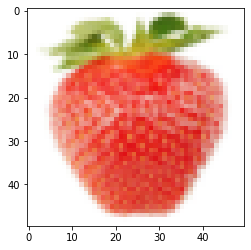

In [13]:
image, label = dataset[0]
plt.imshow(image.permute(1, 2, 0))
print('Label:', label)

In [14]:
classes = dataset.classes

In [15]:
for set in [dataset, test_dataset]:
    counts = dict()
    for image, label in set:
        counts[classes[label]] = counts.get(classes[label], 0) + 1
    print(counts)

{'O': 12565, 'R': 9999}
{'O': 1401, 'R': 1112}


In [16]:
torch.manual_seed(123)
val_size = 1260
train_size = len(dataset) - val_size

In [17]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(21304, 1260)

In [18]:
# Hyperparmeters
batch_size = 128
epochs = 10
learning_rate = 0.001

# Other constants
input_size = 3*50*50
num_classes = 2
opt_func = torch.optim.SGD

In [19]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 3, 50, 50])


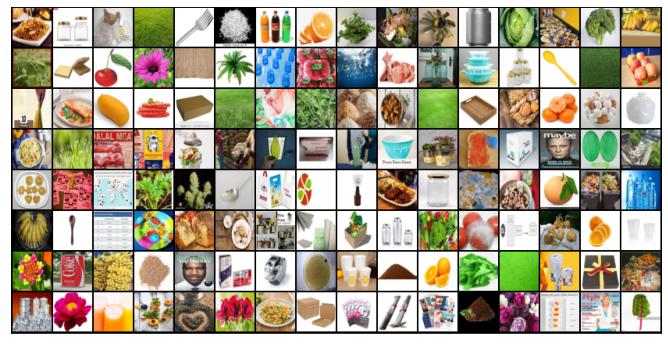

In [20]:
def show_batch(dataset_loader):
    for images, labels in dataset_loader:
        print('images.shape:', images.shape)
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

## Baseline - Simple Logistic Model

In [21]:
# Logistic Model
class WasteLogistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        #xb = xb.reshape(-1, 3*100*100)
        xb = torch.flatten(xb, start_dim=1, end_dim=-1)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = WasteLogistModel()

In [22]:
# Training
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [23]:
evaluate(model, val_loader)

{'val_acc': 0.4367717206478119, 'val_loss': 0.7106560468673706}

In [24]:
history = fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4894, val_acc: 0.7982
Epoch [1], val_loss: 0.4913, val_acc: 0.7683
Epoch [2], val_loss: 0.4854, val_acc: 0.7988
Epoch [3], val_loss: 0.5069, val_acc: 0.7518
Epoch [4], val_loss: 0.4609, val_acc: 0.8015
Epoch [5], val_loss: 0.4629, val_acc: 0.8086
Epoch [6], val_loss: 0.4614, val_acc: 0.7928
Epoch [7], val_loss: 0.4562, val_acc: 0.8082
Epoch [8], val_loss: 0.4692, val_acc: 0.7824
Epoch [9], val_loss: 0.4587, val_acc: 0.7953


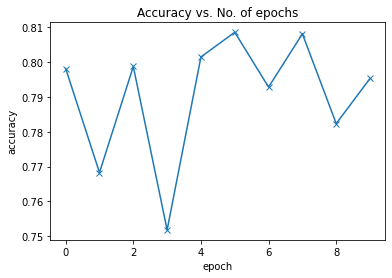

In [25]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [26]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_acc': 0.8687126040458679, 'val_loss': 0.3881024122238159}

In [27]:
# Predicting images and presenting
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 1 , Predicted: 1


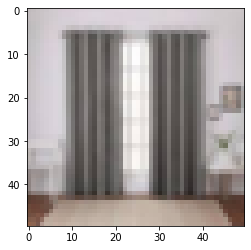

In [28]:
img, label = test_dataset[1548]
plt.imshow(img.permute(1, 2, 0))
print('Label:', label, ', Predicted:', predict_image(img, model))

In [29]:
torch.save(model.state_dict(), 'waste-logist.pth')

In [30]:
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 71kB 3.4MB/s 


In [32]:
import jovian
jovian.utils.colab.set_colab_file_id('1oi0l4TUnR0lHCF7UCfIN-hw3HUzgO7KZ')

In [33]:
jovian.commit(project=project_name, environment=None, outputs=['waste-logist.pth'])

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Committed successfully! https://jovian.ai/devendrachauhan299/waste-classification


'https://jovian.ai/devendrachauhan299/waste-classification'

## Using GPU device

In [35]:
torch.cuda.is_available()

False

In [36]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [37]:
device = get_default_device()
device

device(type='cpu')

In [38]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Simple FeedForward with hidden layers

In [39]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class WasteClassBase(nn.Module):    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [40]:
class WasteFFModel(WasteClassBase):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, 64) # hidden layer
        self.linear2 = nn.Linear(64, 128) # hidden layer 2
        self.linear3 = nn.Linear(128, out_size) # output layer
        
    def forward(self, xb):
        
        out = torch.flatten(xb, start_dim=1, end_dim=-1) # Flatten the image tensors
        out = self.linear1(out) # Get intermediate outputs using hidden layer 1
        out = F.relu(out)       # Apply activation function
        out = self.linear2(out) # Get intermediate outputs using hidden layer 2
        out = F.relu(out)       # Apply activation function
        out = self.linear3(out) # Get predictions using output layer
        return out

In [41]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [42]:
model = WasteFFModel(input_size, out_size=num_classes)
to_device(model, device)

WasteFFModel(
  (linear1): Linear(in_features=7500, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=2, bias=True)
)

In [43]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.470564067363739, 'val_loss': 0.6930290460586548}]

In [44]:
history += fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [0], train_loss: 0.6716, val_loss: 0.6491, val_acc: 0.7704
Epoch [1], train_loss: 0.6303, val_loss: 0.6068, val_acc: 0.7788
Epoch [2], train_loss: 0.5876, val_loss: 0.5641, val_acc: 0.7884
Epoch [3], train_loss: 0.5482, val_loss: 0.5301, val_acc: 0.7923
Epoch [4], train_loss: 0.5184, val_loss: 0.5108, val_acc: 0.7816
Epoch [5], train_loss: 0.4978, val_loss: 0.4919, val_acc: 0.7912
Epoch [6], train_loss: 0.4852, val_loss: 0.4805, val_acc: 0.7936
Epoch [7], train_loss: 0.4767, val_loss: 0.4759, val_acc: 0.7936
Epoch [8], train_loss: 0.4714, val_loss: 0.4717, val_acc: 0.7936
Epoch [9], train_loss: 0.4680, val_loss: 0.4713, val_acc: 0.7927


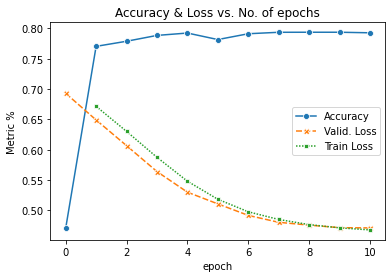

In [47]:
def plot_metrics(history):
    metrics = pd.DataFrame({'Accuracy': [x['val_acc'] for x in history], 
                            'Valid. Loss': [x['val_loss'] for x in history],
                           'Train Loss': [x.get('train_loss') for x in history]})

    sns.lineplot(data=metrics, markers=True)

    plt.xlabel('epoch')
    plt.ylabel('Metric %')
    plt.legend(['Accuracy', 'Valid. Loss', 'Train Loss'])
    plt.title('Accuracy & Loss vs. No. of epochs');
    
plot_metrics(history)

In [48]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device) # Convert to a batch of 1
    yb = model(xb) # Get predictions from model
    _, preds  = torch.max(yb, dim=1) # Pick index with highest probability
    return dataset.classes[preds[0].item()]

Label: O , Predicted: O


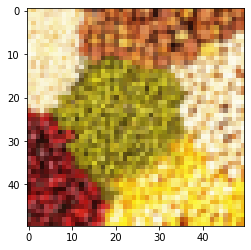

In [51]:
# Testing samples
img, label = test_dataset[850]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [52]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_acc': 0.8592889904975891, 'val_loss': 0.3975765109062195}

In [55]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/devendrachauhan299/waste-classification


'https://jovian.ai/devendrachauhan299/waste-classification'

## **Simple CNN Model**

In [56]:
# Clearing CUDA memory cache
torch.cuda.empty_cache()

In [57]:
class WasteCnnModel(WasteClassBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 25 x 25

            nn.Flatten(), 
            nn.Linear(64*25*25, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [58]:
model = WasteCnnModel()
to_device(model, device)

WasteCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=40000, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [59]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.56577068567276, 'val_loss': 0.6928009390830994}]

In [60]:
history += fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [0], train_loss: 0.6884, val_loss: 0.6838, val_acc: 0.5768
Epoch [1], train_loss: 0.6819, val_loss: 0.6772, val_acc: 0.5784
Epoch [2], train_loss: 0.6746, val_loss: 0.6689, val_acc: 0.6851
Epoch [3], train_loss: 0.6647, val_loss: 0.6569, val_acc: 0.7129
Epoch [4], train_loss: 0.6505, val_loss: 0.6404, val_acc: 0.7430
Epoch [5], train_loss: 0.6303, val_loss: 0.6165, val_acc: 0.7494
Epoch [6], train_loss: 0.6035, val_loss: 0.5864, val_acc: 0.7502
Epoch [7], train_loss: 0.5714, val_loss: 0.5545, val_acc: 0.7553
Epoch [8], train_loss: 0.5393, val_loss: 0.5249, val_acc: 0.7591
Epoch [9], train_loss: 0.5153, val_loss: 0.5114, val_acc: 0.7522


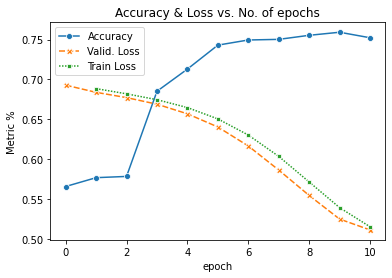

In [61]:
plot_metrics(history)

Label: O , Predicted: O


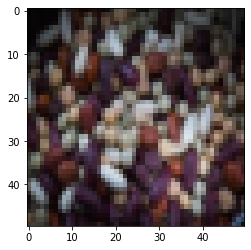

In [62]:
# Testing samples
img, label = test_dataset[950]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [63]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_acc': 0.8391914367675781, 'val_loss': 0.4446846842765808}

In [65]:
jovian.commit(project=project_name, environment=None, outputs=['waste-cnn.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...


[jovian] Error: Ignoring "waste-cnn.pth" (not found)


[jovian] Committed successfully! https://jovian.ai/devendrachauhan299/waste-classification


'https://jovian.ai/devendrachauhan299/waste-classification'

##  Conclusion


At this point 3 different models were ran: a Logistic Regression; a FeedForward NN and a simple CNN model. Surprisingly, results were very similar throughout the three models, with validation loss around 0.40 ~ 0.50 and validation accuracy of around 80% ~ 86%. 

Thanks to the convolutional layers, the CNN model presented less training and validation losses than the FeedForward method, even though validation accuracy was slightly behind. Complemented with One Cycle learning rate and the Adam optimizer the model almost reached 86% accuracy. Accounting that only basic models were used, the results were not so much satisfying although the complexity of the model is fairly low, which also presents opportunity for even further experimenting.